# Video Segmentation Data

For reasons of space, we have only included the processed video data (embedded with a VAE) in the github repository. The VAE and the code to create this embedding can be found in a seperate repository: [ProjectSEM/VAE-video](https://github.com/ProjectSEM/VAE-video)





In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
Z = np.load('data/videodata/video_color_Z_embedded_64.npy')


# the "Sax" movie is from time slices 0 to 5537
sax = Z[0:5537, :]
bed = Z[5537:5537 + 10071, :]
dishes = Z[5537 + 10071: 5537 + 10071 + 7633, :]

In [3]:
# plot the prior of the variance vs an empirical estimate

from scipy.stats import chi2, multivariate_normal

df0 = 10.
scale0 = 0.3


mode = df0 * scale0 / (df0 + 2)

## plot the prior variance distribution
# sns.distplot(pd.Series([(df0*scale0)/chi2.rvs(df0) for _ in range(1000)]), label='prior')
# print("Prior variance (mode): {}".format(mode))
# ylim = plt.gca().get_ylim()
# plt.plot([mode, mode], ylim, 'r:')
# plt.ylim(ylim)
# sns.distplot(np.var(sax[0:, :], axis=0), label='variance of features')
# print("Median Feature variance: {}".format(np.median(np.var(sax[0:, :], axis=0))))
# plt.legend()
f_prior = multivariate_normal.logpdf(np.mean(Z, axis=0), mean=np.zeros(Z.shape[1]), cov=np.eye(Z.shape[1]) * mode)
f_prior


-23.354194375544512

Using TensorFlow backend.


TensorFlow Version: 1.9.0
Keras      Version: 2.2.0


Run SEM: 100%|██████████| 7633/7633 [45:40<00:00,  2.79it/s]


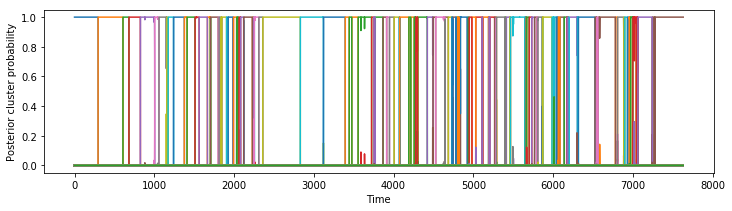

In [4]:
# import tensorflow as tf
from models import *

d = np.shape(sax)[1]

l2_regularization = 0.0
dropout = 0.5

f_class = GRUEvent
f_opts=dict(var_df0=df0, var_scale0=scale0, 
            l2_regularization=l2_regularization, 
            dropout=dropout,
            n_epochs=10, t=10,
            prior_log_prob=f_prior
           )

lmda = 10**5
alfa = 10**-1

Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'f_class': f_class,
    'f_opts': f_opts
}


# x = sax[0:1500]
# x = sax
x = dishes

sem_model = SEM(**Omega)
sem_model.run(x, k=x.shape[0], progress_bar=True)

# get the MAP event models
y_hat = sem_model.results.e_hat


# print "Adjusted Rand Index:", r
plt.figure(figsize=(12, 3.0))
plt.plot(sem_model.results.post)
plt.gca().set_ylabel('Posterior cluster probability')
plt.gca().set_xlabel('Time')
plt.show()
# tf.Session().close()

In [7]:
from video_segmentation import load_comparison_data
human_data_path = './data/'
data = pd.read_csv(human_data_path + 'zachs2006_data021011', delimiter='\t')
binned_sax, binned_bed, binned_dishes = load_comparison_data(data)

In [8]:
data = pd.read_csv(human_data_path + 'zachs2006_data021011', delimiter='\t')

def bin_times(array, max_seconds, bin_size=1.0):
    cumulative_binned = [np.sum(array <= t0 * 1000) for t0 in np.arange(bin_size, max_seconds + bin_size, bin_size)]
    binned = np.array(cumulative_binned)[1:] - np.array(cumulative_binned)[:-1]
    binned = np.concatenate([[cumulative_binned[0]], binned])
    return binned


def get_subjs_rpb(data, bin_size=1.0):
    # get the grouped data
#     binned_sax, binned_bed, binned_dishes = load_comparison_data(data)
    grouped_data = np.concatenate(load_comparison_data(data))
    
    r_pbs = []
    
    for sj in set(data.SubjNum):
        _binned_sax =  bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'A'), 'MS'], 185, 1.0)
        _binned_bed =  bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'B'), 'MS'], 336, 1.0)
        _binned_dishes =  bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'C'), 'MS'], 255, 1.0)
        subs = np.concatenate([_binned_sax, _binned_bed, _binned_dishes])
        
        r_pbs.append(get_point_biserial(subs, grouped_data))
    return r_pbs
    


In [11]:
# get the point biserial correlation coefficient

def get_binned_boundaries(posterior, bin_size=1.0, frequency=30.0):
    
    e_hat = np.argmax(sem_model.results.post, axis=1)
    
    frame_time = np.arange(1, len(e_hat) + 1) / float(frequency)
    index = np.arange(0, np.max(frame_time), bin_size)

    boundaries = np.concatenate([[0], e_hat[1:] !=e_hat[:-1]])

    boundaries_binned = []
    for t in index:
        boundaries_binned.append(np.sum(
            boundaries[(frame_time >= t) & (frame_time < (t + bin_size))]
        ))
    return np.array(boundaries_binned, dtype=bool) 

def get_point_biserial(boundaries_binned, binned_comp):
    M_1 = np.mean(binned_comp[boundaries_binned == 1])
    M_0 = np.mean(binned_comp[boundaries_binned == 0])

    n_1 = np.sum(boundaries_binned == 1)
    n_0 = np.sum(boundaries_binned == 0)
    n = n_1 + n_0

    s = np.std(binned_comp)
    r_pb = (M_1 - M_0) / s * np.sqrt(n_1 * n_0 / (float(n)**2))
    return r_pb

boundaries = get_binned_boundaries(sem_model.results.post)

get_point_biserial(boundaries, binned_dishes)

0.1953981906969642

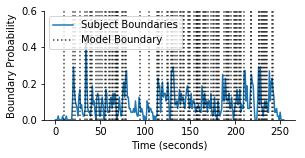

In [12]:
plt.figure(figsize=(4.5, 2.0))
plt.plot(binned_dishes, label='Subject Boundaries')
plt.xlabel('Time (seconds)')
plt.ylabel('Boundary Probability')

b = np.arange(len(boundaries))[boundaries][0]
plt.plot([b, b], [0, 1], 'k:', label='Model Boundary', alpha=0.75)
for b in np.arange(len(boundaries))[boundaries][1:]:
    plt.plot([b, b], [0, 1], 'k:', alpha=0.75)

plt.legend(loc='upper left')
plt.ylim([0, 0.6])
sns.despine()


In [13]:
np.arange(len(boundaries))[boundaries]

array([  9,  20,  22,  27,  33,  35,  38,  39,  41,  45,  47,  50,  52,
        55,  56,  60,  61,  63,  64,  66,  67,  68,  69,  70,  74,  75,
        77,  78,  94, 104, 113, 114, 115, 118, 124, 125, 128, 130, 131,
       133, 135, 139, 140, 142, 143, 147, 149, 150, 154, 156, 157, 158,
       159, 160, 161, 164, 165, 166, 167, 170, 173, 175, 176, 179, 180,
       181, 182, 188, 190, 191, 192, 193, 195, 199, 200, 201, 202, 204,
       205, 206, 210, 217, 218, 226, 227, 229, 230, 231, 232, 233, 234,
       235, 241, 242])

In [14]:
from video_segmentation import load_comparison_data
human_data_path = './data/'
data = pd.read_csv(human_data_path + 'zachs2006_data021011', delimiter='\t')
binned_sax, binned_bed, binned_dishes = load_comparison_data(data, bin_size=1.0)

array([130, 238, 211, 210,  79, 131,  20, 228, 226,  34])

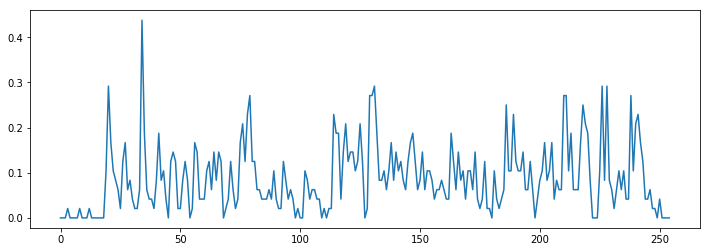

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(binned_dishes, alpha=1.0)
np.argsort(binned_dishes)[-10:]

0.5656171932224218

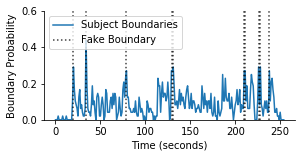

In [16]:
fake_boundaries = np.zeros(np.shape(binned_dishes), dtype=bool) 
fake_boundaries[np.argsort(binned_dishes)[-10:]] = True

plt.figure(figsize=(4.5, 2.0))
plt.plot(binned_dishes, label='Subject Boundaries')
plt.xlabel('Time (seconds)')
plt.ylabel('Boundary Probability')

b = np.arange(len(fake_boundaries))[fake_boundaries][0]
plt.plot([b, b], [0, 1], 'k:', label='Fake Boundary', alpha=0.75)
for b in np.arange(len(fake_boundaries))[fake_boundaries][1:]:
    plt.plot([b, b], [0, 1], 'k:', alpha=0.75)

plt.legend(loc='upper left')
plt.ylim([0, 0.6])
sns.despine()

get_point_biserial(fake_boundaries, binned_dishes)

Maximum possible r_pb: 0.805633442611


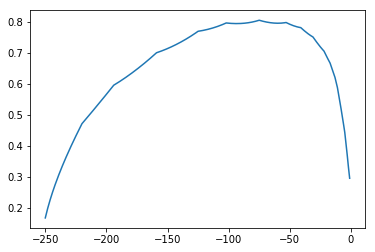

In [17]:
r_pb = []
for ii in xrange(-250, 0, 1):
    fake_boundaries = np.zeros(np.shape(binned_dishes), dtype=bool) 
    fake_boundaries[np.argsort(binned_dishes)[ii:]] = True
    r_pb.append(get_point_biserial(fake_boundaries, binned_dishes))
plt.plot(range(-250, 0, 1), r_pb)
print "Maximum possible r_pb: {}".format(np.max(r_pb))

In [18]:
def get_binned_boundary_prop(log_post, bin_size=1.0, frequency=30.0):
    """
    :param results: SEM.Results
    :param bin_size: seconds
    :param frequency: in Hz
    :return:
    """
    
    e_hat = np.argmax(log_post, axis=1)

    # normalize
    log_post0 = log_post - np.tile(np.max(log_post, axis=1).reshape(-1, 1), (1, log_post.shape[1]))
    log_post0 -= np.tile(logsumexp(log_post0, axis=1).reshape(-1, 1), (1, log_post.shape[1]))

    boundary_probability = [0]
    for ii in range(1, log_post0.shape[0]):
        idx = range(log_post0.shape[0])
        idx.remove(e_hat[ii - 1])
        boundary_probability.append(logsumexp(log_post0[ii, idx]))
    boundary_probability = np.array(boundary_probability)

    frame_time = np.arange(1, len(boundary_probability) + 1) / float(frequency)

    index = np.arange(0, np.max(frame_time), bin_size)
    boundary_probability_binned = []
    for t in index:
        boundary_probability_binned.append(
            # note: this operation is equivalent to the log of the average boundary probability in the window
            logsumexp(boundary_probability[(frame_time >= t) & (frame_time < (t + bin_size))]) - \
            np.log(bin_size * 30.)
        )
    boundary_probability_binned = pd.Series(boundary_probability_binned, index=index)
    return boundary_probability_binned

boundary_prop = get_binned_boundary_prop(sem_model.results.log_prior + sem_model.results.log_like)

/anaconda3/envs/sem/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  del sys.path[0]
/anaconda3/envs/sem/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/envs/sem/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


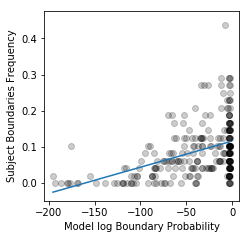

In [19]:
plt.figure(figsize=(3.5, 3.5))
plt.scatter(boundary_prop, binned_dishes, color='k', alpha=0.2)
plt.ylabel('Subject Boundaries Frequency')
plt.xlabel('Model log Boundary Probability')
x = boundary_prop
y = binned_dishes
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))


In [20]:
r_pbs = get_subjs_rpb(data)

In [22]:
# get the permutation r_pb
_boundaries = np.copy(boundaries)
n_permute = 500
r_pb_permuted = []
for ii in range(n_permute):
    np.random.shuffle(_boundaries)
    r_pb_permuted.append(get_point_biserial(_boundaries, binned_dishes))

/anaconda3/envs/sem/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


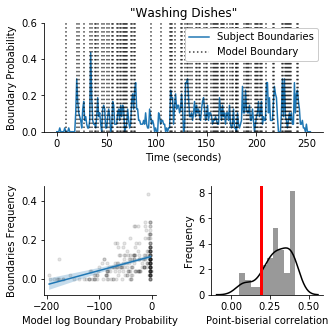

In [26]:
import statsmodels.api as sm
from scipy import stats


plt.figure(figsize=(5.0, 5.0))
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)

plt.plot(binned_dishes, label='Subject Boundaries')
plt.xlabel('Time (seconds)')
plt.ylabel('Boundary Probability')

b = np.arange(len(boundaries))[boundaries][0]
plt.plot([b, b], [0, 1], 'k:', label='Model Boundary', alpha=0.75)
for b in np.arange(len(boundaries))[boundaries][1:]:
    plt.plot([b, b], [0, 1], 'k:', alpha=0.75)

plt.legend(loc='upper right', framealpha=1.0)
plt.ylim([0, 0.6])
plt.title('"Washing Dishes"')
sns.despine()

ax = plt.subplot2grid((2, 2), (1, 0), colspan=1)
plt.scatter(boundary_prop, binned_dishes, color='k', s=10, alpha=0.1)
plt.ylabel('Boundaries Frequency')
plt.xlabel('Model log Boundary Probability')
x = boundary_prop
y = binned_dishes
y = y[np.argsort(x)]
x = np.sort(x)
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
y_hat = res.predict(X)
plt.plot(x, res.predict(X))

n = len(y_hat)
dof = n - res.df_model - 1
t = stats.t.ppf(1-0.025, df=dof)
s_err = np.sum(np.power(y - y_hat, 2))
conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x-np.mean(x)),2) /
            ((np.sum(np.power(x,2))) - n*(np.power(np.mean(x),2))))))

upper = y_hat + abs(conf)
lower = y_hat - abs(conf)
plt.fill_between(x, lower, upper, alpha=0.25)

ax = plt.subplot2grid((2, 2), (1, 1), colspan=1)
x = 'Model Subjects'.split()
sns.distplot(r_pbs,  ax=ax, norm_hist=False, label='Subjects', bins=10, color='k')
r_pb_model = get_point_biserial(boundaries, binned_dishes)
lb, ub = ax.get_ylim()
plt.plot([r_pb_model, r_pb_model], [0, ub], 'r', label='Model', lw='3')
plt.xlabel(r'Point-biserial correlation')
plt.ylabel('Frequency')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
sns.despine()
plt.savefig('Segmentation_dishes.pdf', dpi=600, bbox_inches='tight')

In [27]:
e_hat = sem_model.results.e_hat.copy()
log_post = sem_model.results.log_prior.copy() + sem_model.results.log_like.copy()
# normalize
log_post0 = log_post - np.tile(np.max(log_post, axis=1).reshape(-1, 1), (1, log_post.shape[1]))
log_post0 -= np.tile(logsumexp(log_post0, axis=1).reshape(-1, 1), (1, log_post.shape[1]))

boundary_probability = [0]
for ii in range(1, log_post0.shape[0]):
    idx = range(log_post0.shape[0])
    idx.remove(e_hat[ii - 1])
    boundary_probability.append(logsumexp(log_post0[ii, idx]))
boundary_probability = np.array(boundary_probability)

/anaconda3/envs/sem/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  """
/anaconda3/envs/sem/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
fig, axes = plt.subplots(2, 1)

axes[0].plot(sem_model.results.log_like)
axes[0].set_title('Log Likelihoods')


axes[1].plot(sem_model.results.log_prior)
axes[1].set_title('Log Priors')
axes[1].set_xlabel('Time')

plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
np.sum(sem_model.results.pe)

In [ ]:
# print "Adjusted Rand Index:", r
plt.figure(figsize=(12, 3.0))
plt.plot(sem_model.results.post)

def zero_one_scale(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

time_points = np.shape(sem_model.results.post)[0]
# plt.plot(range(1, time_points), zero_one_scale(movement[:time_points-1]), 'k', alpha=0.5)
plt.gca().set_ylabel('Posterior cluster probability')
plt.gca().set_xlabel('Time')

plt.show()
# tf.Session().close()

In [ ]:
boundaries = y_hat[:-1] != y_hat[1:]
x = np.arange(1, len(boundaries) + 1) / 30.0


# # np.arange(np.shape(sax)[0], dtype='float') / 30.0
sns.set_context('talk')
plt.subplots(1, 1, figsize=(7.5, 3.0))
# plt.plot(np.arange(1, np.shape(sem.results.pe)[0]+1, dtype='float') / 30.0, zero_one_scale(sem.results.pe))

# young_warned_sax = pd.read_csv('zachs_2006_young_warned.csv', header=-1)
# young_warned_sax.set_index(0, inplace=True)
# plt.plot(young_warned_sax.index, young_warned_sax[1], 'r', alpha=0.5, label='Human Subjects (Young Warned)')

young_warned_sax = pd.read_csv('data/zachs_2006_young_unwarned.csv', header=-1)
young_warned_sax.set_index(0, inplace=True)
plt.plot(young_warned_sax.index, young_warned_sax[1], 'k', alpha=1.0, label='Human Subjects')

# plt.fill_between(x, boundaries, alpha=0.1, label='SEM Event Boundaries')
plt.plot(x, boundaries, 'k:', alpha=0.2, label='SEM Event Boundaries')

plt.ylabel('Boundary Probability')
plt.xlabel('Time (seconds)')

plt.legend(loc='upper left',)
sns.despine()

# plt.savefig('MLPEventsVsHuman.png', dpi=300)

